# Customer Behaivor Prediction (1) - Bike Buyer

## Overview
In 1998, the Adventure Works Cycles company collected a large volume of data about their existing customers, including demographic features and information about purchases they have made. The company is particularly interested in analyzing customer data to determine any apparent relationships between demographic features known about the customers and the likelihood of a customer purchasing a bike. Additionally, the analysis should endeavor to determine whether a customer's average monthly spend with the company can be predicted from known customer characteristics.

## Goal
The goal is to build a classification model to predict the likelihood of a customer purchasing a bike.

## Data
The training and test datasets are retrieved from [Microsoft Learning](https://github.com/MicrosoftLearning).

## Model
We are adopting a simple logistic regression model to predict the likelihood of a customer purchasing a bike. Evaluated with cross-validation on the training data, the simple model gives an AUC of **0.84**.

## Import the libraries

In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import seaborn as sns
import matplotlib.pyplot as plt
import math

## Load the data

In [2]:
# LOAD DATA
custs = pd.read_csv('D:\\Users\\user\\Desktop\\MPP DS Cert\\DAT275x - Principles of Machine Learning Python Edition\\AdvWorksCusts.csv')
avgms = pd.read_csv('D:\\Users\\user\\Desktop\\MPP DS Cert\\DAT275x - Principles of Machine Learning Python Edition\\AW_AveMonthSpend.csv')
bikeby = pd.read_csv('D:\\Users\\user\\Desktop\\MPP DS Cert\\DAT275x - Principles of Machine Learning Python Edition\\AW_BikeBuyer.csv')

## Drop duplicates

In [3]:
#DROP DUPLICATES
custs = custs.drop_duplicates(keep = 'last')
avgms = avgms.drop_duplicates(keep = 'last')
bikeby = bikeby.drop_duplicates(keep = 'last')

In [4]:
#MERGE CSVS
custs = pd.merge(custs, avgms, on='CustomerID')
custs = pd.merge(custs, bikeby, on='CustomerID')
# print(custs.info())

## Feature engineering

In [5]:
#CREATE AGE
custs['Today'] = pd.Timestamp("1998-01-01")
custs['BirthDate'] = pd.to_datetime(custs['BirthDate'])
custs['Age'] = custs['Today'] - custs['BirthDate']
custs['Age'] = custs['Age']/np.timedelta64(1,'Y')
custs['Age'] = custs['Age'].round()

#CHECK FOR CLASS IMBALANCE
bb_counts = custs[['CustomerID', 'BikeBuyer']].groupby('BikeBuyer').count()
# print(bb_counts) #only 1/3 are bikebuyers
# print(custs.info())

## Define our label

In [6]:
#create label
labels = np.array(custs['BikeBuyer'])

## One-hot encode categorical features

In [7]:
#Create categorical feature array
def encode_string(cat_features):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

categorical_columns = ['Education', 'Occupation', 'Gender', 'MaritalStatus']

Features = encode_string(custs['CountryRegionName'])
for col in categorical_columns:
    temp = encode_string(custs[col])
    Features = np.concatenate([Features, temp], axis = 1)

# print(Features.shape)
# print(Features[:2, :])
# print(custs['CountryRegionName'].unique())

#Concatenate with numeric features
Features = np.concatenate([Features, np.array(custs[
                                                  ['HomeOwnerFlag', 'NumberCarsOwned', 'NumberChildrenAtHome',
                                                      'TotalChildren', 'YearlyIncome', 'AveMonthSpend', 'Age']
                                              ])], axis = 1)
# print(Features.shape)
# print(Features[:2, :])

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used

## Create training and test sets

In [8]:
#Split the data
nr.seed(8585)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 4000)
X_train = Features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(labels[indx[1]])

## Scale the data

In [9]:
#Scale the data
scaler = preprocessing.StandardScaler().fit(X_train[:,21:])
X_train[:,21:] = scaler.transform(X_train[:,21:])
X_test[:,21:] = scaler.transform(X_test[:,21:])
# print(X_train[:2,])

## Create the model

In [10]:
#Construct the logistic regression model WITH CLASS WEIGHT
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.45, 1:0.55})
logistic_mod.fit(X_train, y_train)
# print(logistic_mod.intercept_)
# print(logistic_mod.coef_)
probabilities = logistic_mod.predict_proba(X_test)
# print(probabilities[:15,:])

#Score and evaluate the classification model
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)
print(np.array(scores[:15]))
print(y_test[:15])

[0 1 0 1 1 0 0 0 0 0 1 0 0 0 0]
[0 1 0 1 1 0 0 0 0 0 0 0 0 0 0]


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Evaluate the model

In [11]:
#Display performance metrics
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0, 0] + '             %5d' % conf[0, 1])
    print('Actual negative    %6d' % conf[1, 0] + '             %5d' % conf[1, 1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])
print_metrics(y_test, scores)

                 Confusion matrix
                 Score positive    Score negative
Actual positive      2336               320
Actual negative       543               801

Accuracy  0.78
 
           Positive      Negative
Num case     2656          1344
Precision    0.81          0.71
Recall       0.88          0.60
F1           0.84          0.65


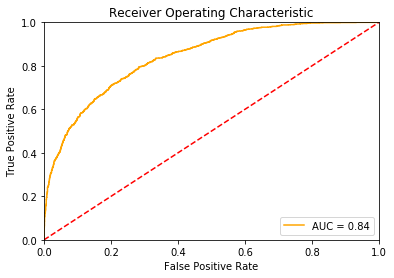

In [12]:
#Compute ROC and AUC
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:, 1])
    auc = sklm.auc(fpr, tpr)

    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f' % auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
plot_auc(y_test, probabilities)

## Create the submission file

In [ ]:
#Export as csv
# custs.to_csv('classification_test_result.csv')